In [1]:
import torch
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CL-11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data Processing

In [4]:
dataset = r'C:\Datasets\aihumantext\AI_Human.csv'

df = pd.read_csv(dataset)

df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


## Preprocessing

In [5]:
temp_df = df # just incase I want to revert some changes without processing it all over again
df = temp_df

In [6]:
df_ai = df[df['generated'] == 1]
df_human = df[df['generated'] == 0]

df = pd.concat([df_ai, df_human])

df['generated'] = df['generated'].apply(lambda x: int(x))
df['text'] = df['text'].apply(lambda x: str(x).lower())

print(df)

                                                     text  generated
704     this essay will analyze, discuss and prove one...          1
740     i strongly believe that the electoral college ...          1
1262    limiting car use causes pollution, increases c...          1
1378    car-free cities have become a subject of incre...          1
1379    car free cities  car-free cities, a concept ga...          1
...                                                   ...        ...
487229  in "the challenge of exploring venus" the auth...          0
487230  tie face on mars is really just a big misunder...          0
487231  the whole purpose of democracy is to create a ...          0
487233  i dfn't agree with this decision because a lft...          0
487234  richard non, jimmy carter, and bob dole and ot...          0

[487235 rows x 2 columns]


In [7]:
class PreprocessedDataFrame(pd.DataFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._remove_tags()
        self._remove_punctuation()
        self._remove_stopwords()

    def _remove_tags(self):
        tags = ['\n', '\'']
        for tag in tags:
            self['text'] = self['text'].replace(tag, '')

    def _remove_punctuation(self):
        self['text'] = self['text'].apply(lambda text: ''.join([x for x in text if x not in string.punctuation]))

    def _remove_stopwords(self):
        stop_words = set(stopwords.words('english'))
        self['text'] = self['text'].apply(lambda text: ' '.join([word for word in nltk.word_tokenize(text) if word.lower() not in stop_words]))

# Usage:
df = PreprocessedDataFrame(df.sample(10000)) # sampling 10000, change this if you would like to use more/less

In [8]:
df.head()

,text,generated
34639,facial action coding system facs method analyz...,1
177014,think important de churchill important place m...,0
110071,according article unmasking faze mars twentyfi...,0
34784,venus named roman goddess beauty second planet...,1
228937,online schooling failing students examining hu...,0


## Prep

In [9]:
y=df['generated']
X=df['text']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(len(X_train))
print(len(y_train))

7000
7000


In [10]:
max_length = max(len(sentence.split()) for sentence in X_train)
max_length

735

In [11]:
class SimpleTokenizer:
    def __init__(self):
        self.word_index = {'[UNK]': 0} 
        self.index_word = {0: '[UNK]'}
        self.vocab_size = 1 

    def fit_on_texts(self, texts):
        word_count = Counter(word for text in texts for word in text.split())
        for word, _ in word_count.items():
            if word not in self.word_index:
                self.word_index[word] = self.vocab_size
                self.index_word[self.vocab_size] = word
                self.vocab_size += 1

    def texts_to_sequences(self, texts):
        return [[self.word_index.get(word, 0) for word in text.split()] if text.split() else [0] for text in texts]

def prepare_data(sequences, word_features, max_length):
    padded_sequences = np.zeros((len(sequences), max_length), dtype=int)
    for i, seq in enumerate(sequences):
        end = min(len(seq), max_length) 
        padded_sequences[i, :end] = seq[:end]
    return (
        torch.tensor(padded_sequences, dtype=torch.long),
        torch.tensor(word_features, dtype=torch.float32),
        torch.tensor([min(len(seq), max_length) for seq in sequences], dtype=torch.long)
    )

def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.isalpha() and token not in stop_words]

all_words = [word for text in df['text'] for word in tokenize_text(text)]
word_counts = Counter(all_words)

top_words = [word for word, _ in word_counts.most_common(500)]

def create_word_features(text):
    tokens = tokenize_text(text)
    return [1 if word in tokens else 0 for word in top_words]

tokenizer = SimpleTokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_features_train = [create_word_features(text) for text in X_train] # word features are not actually being used, this is from a previous implementation before I had a good grasp on the preprocessing steps
X_train_tensor, word_features_train_tensor, lengths = prepare_data(sequences, word_features_train, max_length)

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, word_features_train_tensor, lengths, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

sequences_valid = tokenizer.texts_to_sequences(X_val)
word_features_valid = [create_word_features(text) for text in X_val]
X_valid_tensor, word_features_valid_tensor, lengths_valid = prepare_data(sequences_valid, word_features_valid, max_length)
y_valid_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
valid_dataset = TensorDataset(X_valid_tensor, word_features_valid_tensor, lengths_valid, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [12]:
max_length = max(len(seq) for seq in sequences)  # ensuring that its the same from earlier
X_train_tensor, word_features_train_tensor, lengths_train = prepare_data(sequences, word_features_train, max_length)
X_valid_tensor, word_features_valid_tensor, lengths_valid = prepare_data(sequences_valid, word_features_valid, max_length)

In [13]:
print("Original lengths:", [len(seq) for seq in sequences[:5]])
print("Padded lengths:", lengths_train[:5].tolist())
print("Sample padded sequences:", X_train_tensor[:5])

Original lengths: [202, 216, 464, 173, 197]
Padded lengths: [202, 216, 464, 173, 197]
Sample padded sequences: tensor([[  1,   2,   3,  ...,   0,   0,   0],
        [174, 175, 174,  ...,   0,   0,   0],
        [264, 265, 266,  ...,   0,   0,   0],
        [548, 549, 550,  ...,   0,   0,   0],
        [117, 646, 258,  ...,   0,   0,   0]])


In [14]:
vocab_size = tokenizer.vocab_size
print("Vocabulary size:", vocab_size)

Vocabulary size: 33866


In [15]:
for i, (sequences, word_features, lengths, labels) in enumerate(valid_loader):
    if (lengths == 0).any():
        print(f"Batch {i} contains one or more sequences with a length of 0.")

In [16]:
print("Maximum sequence length for training:", max_length)
print("Training Data Shape:", X_train_tensor.shape)
print("Validation Data Shape:", X_valid_tensor.shape)

Maximum sequence length for training: 735
Training Data Shape: torch.Size([7000, 735])
Validation Data Shape: torch.Size([1500, 735])


# Text-CNN

In [19]:
train_loss_history = []
valid_loss_history = []

num_classes = 1
MAX_SEQUENCE_LENGTH = max_length

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes=1, max_seq_length=MAX_SEQUENCE_LENGTH):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv1 = nn.Conv1d(embed_size, 128, kernel_size=4, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=4, padding='same')
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=4, padding='same')
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()

        output_length = max_seq_length // (2**3) 
        flattened_output_size = 32 * output_length

        self.fc1 = nn.Linear(flattened_output_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        if num_classes == 1:
            x = self.output_act(x)
        return x
    
vocab_size = tokenizer.vocab_size  # Adjust as necessary
embed_size = 300
model = TextCNN(vocab_size, embed_size).to(device) 
print(model)

def train(ckpts_path, model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    try:
        checkpoint = torch.load(f'{ckpts_path}/best_text_cnn1_classifier.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        train_loss_history = checkpoint['train_loss_history']
        valid_loss_history = checkpoint['valid_loss_history']
        best_loss = min(valid_loss_history)
        print("Found checkpoint.")
    except:
        print("Found no checkpoint.")
        best_loss = float('inf')
        train_loss_history = []
        valid_loss_history = []

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for sequences, word_features, lengths, labels in tqdm(train_loader):
            sequences, word_features, labels = sequences.to(device), word_features.to(device), labels.to(device)
            optimizer.zero_grad()  
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels.float()) 
            loss.backward()
            optimizer.step() 
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        model.eval() 
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, word_features, lengths, labels in tqdm(val_loader):
                sequences, word_features, labels = sequences.to(device), word_features.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels.float())
                val_running_loss += loss.item() * sequences.size(0)
                predicted = (outputs.squeeze() >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        valid_loss_history.append(val_loss)
        accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'train_loss_history': train_loss_history,
                'valid_loss_history': valid_loss_history
            }, f'{ckpts_path}/best_text_cnn1_classifier.pth')

        try:
            torch.save({
            'model_state_dict': model.state_dict(),
            'train_loss_history': train_loss_history,
            'valid_loss_history': valid_loss_history
        }, f'{ckpts_path}/last_text_cnn1_classifier.pth')
        except:
            pass

    print('Finished Training')

    return train_loss_history, valid_loss_history

    
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_loss_history, valid_loss_history = train("ckpts", model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

TextCNN(
  (embedding): Embedding(33866, 300)
  (conv1): Conv1d(300, 128, kernel_size=(4,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=same)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 32, kernel_size=(4,), stride=(1,), padding=same)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2912, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (output_act): Sigmoid()
)
Found no checkpoint.


100%|██████████| 219/219 [00:02<00:00, 90.48it/s]


Epoch 1/10, Loss: 0.5143


100%|██████████| 47/47 [00:00<00:00, 362.05it/s]


Validation Loss: 0.2557, Accuracy: 89.93%


100%|██████████| 219/219 [00:02<00:00, 90.80it/s]


Epoch 2/10, Loss: 0.1572


100%|██████████| 47/47 [00:00<00:00, 357.43it/s]


Validation Loss: 0.1409, Accuracy: 94.80%


100%|██████████| 219/219 [00:02<00:00, 91.19it/s]


Epoch 3/10, Loss: 0.0835


100%|██████████| 47/47 [00:00<00:00, 359.48it/s]


Validation Loss: 0.1032, Accuracy: 95.93%


100%|██████████| 219/219 [00:02<00:00, 91.62it/s]


Epoch 4/10, Loss: 0.0524


100%|██████████| 47/47 [00:00<00:00, 368.33it/s]


Validation Loss: 0.0932, Accuracy: 96.67%


100%|██████████| 219/219 [00:02<00:00, 90.31it/s]


Epoch 5/10, Loss: 0.0218


100%|██████████| 47/47 [00:00<00:00, 362.35it/s]


Validation Loss: 0.0925, Accuracy: 96.87%


100%|██████████| 219/219 [00:02<00:00, 90.79it/s]


Epoch 6/10, Loss: 0.0093


100%|██████████| 47/47 [00:00<00:00, 368.08it/s]


Validation Loss: 0.0998, Accuracy: 96.73%


100%|██████████| 219/219 [00:02<00:00, 90.69it/s]


Epoch 7/10, Loss: 0.0033


100%|██████████| 47/47 [00:00<00:00, 361.90it/s]


Validation Loss: 0.1057, Accuracy: 97.00%


100%|██████████| 219/219 [00:02<00:00, 91.45it/s]


Epoch 8/10, Loss: 0.0016


100%|██████████| 47/47 [00:00<00:00, 368.99it/s]


Validation Loss: 0.1097, Accuracy: 96.93%


100%|██████████| 219/219 [00:02<00:00, 90.38it/s]


Epoch 9/10, Loss: 0.0009


100%|██████████| 47/47 [00:00<00:00, 360.64it/s]


Validation Loss: 0.1117, Accuracy: 97.07%


100%|██████████| 219/219 [00:02<00:00, 90.31it/s]


Epoch 10/10, Loss: 0.0006


100%|██████████| 47/47 [00:00<00:00, 348.42it/s]


Validation Loss: 0.1149, Accuracy: 97.13%
Finished Training


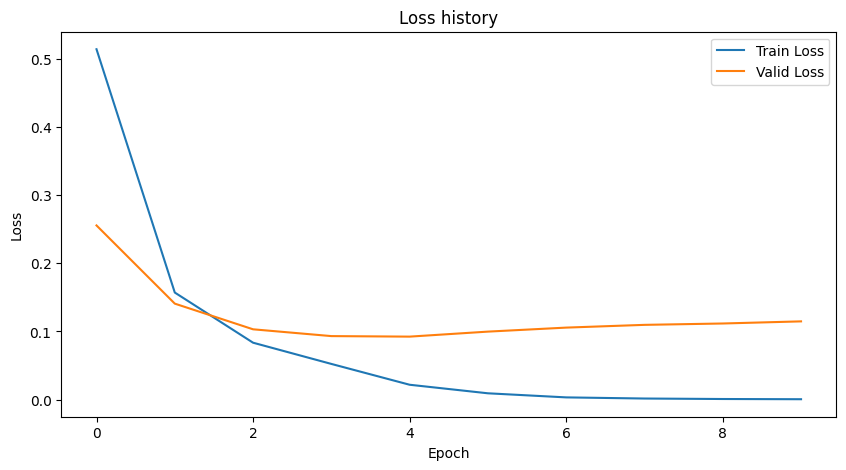

In [20]:
# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def test(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    y_true = []  # Store all true labels
    all_predictions = []  # Store all predictions
    with torch.no_grad():
        for sequences, word_features, lengths, labels in tqdm(test_loader):
            sequences, word_features, labels = sequences.to(device), word_features.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item() * sequences.size(0)
            total_samples += sequences.size(0)
            predictions = (outputs.squeeze() > 0.5).long()  # Get predictions
            correct_preds += predictions.eq(labels).sum().item()
            y_true.extend(labels.tolist())
            all_predictions.extend(predictions.tolist())  # Add predictions to list

    test_loss = running_loss / total_samples
    accuracy = correct_preds / total_samples
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
    print(f'Predictions: {all_predictions}')  # Print all predictions

    return y_true, all_predictions
y_true, y_pred = test(model, valid_loader, criterion)

print(classification_report(y_val, y_pred))

100%|██████████| 47/47 [00:00<00:00, 351.82it/s]

Test Loss: 0.1149, Accuracy: 0.9713
Predictions: [1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,

# SVC

In [22]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),  # Step 1: CountVectorizer
    ('tfidf_transformer', TfidfTransformer()),  # Step 2: TF-IDF Transformer
    ('naive_bayes', MultinomialNB())])

pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)


print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       896
           1       0.99      0.70      0.82       604

    accuracy                           0.88      1500
   macro avg       0.91      0.85      0.86      1500
weighted avg       0.90      0.88      0.87      1500

